In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()
import scipy

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

import tensorflow_hub as hub

In [2]:
# Getting names of the classes we have
data_directory = pathlib.Path('Shoe vs Sandal vs Boot Dataset')
class_names = sorted([item.name for item in data_directory.glob('*')][:3])
print(class_names)

['Boot', 'Sandal', 'Shoe']


In [3]:
boot_dir = 'Shoe vs Sandal vs Boot Dataset/Boot' 
sandal_dir = 'Shoe vs Sandal vs Boot Dataset/Sandal'
shoe_dir ='Shoe vs Sandal vs Boot Dataset/Shoe'
data_dir = 'Shoe vs Sandal vs Boot Dataset'

In [4]:
boot_images = len(os.listdir(boot_dir))
sandal_images = len(os.listdir(sandal_dir))
shoe_images = len(os.listdir(shoe_dir))
print(f'Number of Boot images: {boot_images}')
print(f'Number of Sandal images: {sandal_images}')
print(f'Number of Shoe images: {shoe_images}')

Number of Boot images: 5000
Number of Sandal images: 5000
Number of Shoe images: 5000


In [24]:
# Defining data generator withour Data Augmentation
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory(data_dir, 
                                          target_size = (224, 224), 
                                          batch_size = 50,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory(data_dir, 
                                        target_size = (224, 224), 
                                        batch_size = 50,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [6]:
images, labels = train_data.next()
len(images), len(labels), images[0].shape

(50, 50, (224, 224, 3))

In [7]:
def plot_random_images():
    """
    Plots 20 Random Images from the dataset
    """
    
    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (10, 10))
    
    for image, label in zip(images, labels):
        plt.subplot(4, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == 21:
            break

    plt.tight_layout()       
    plt.show()

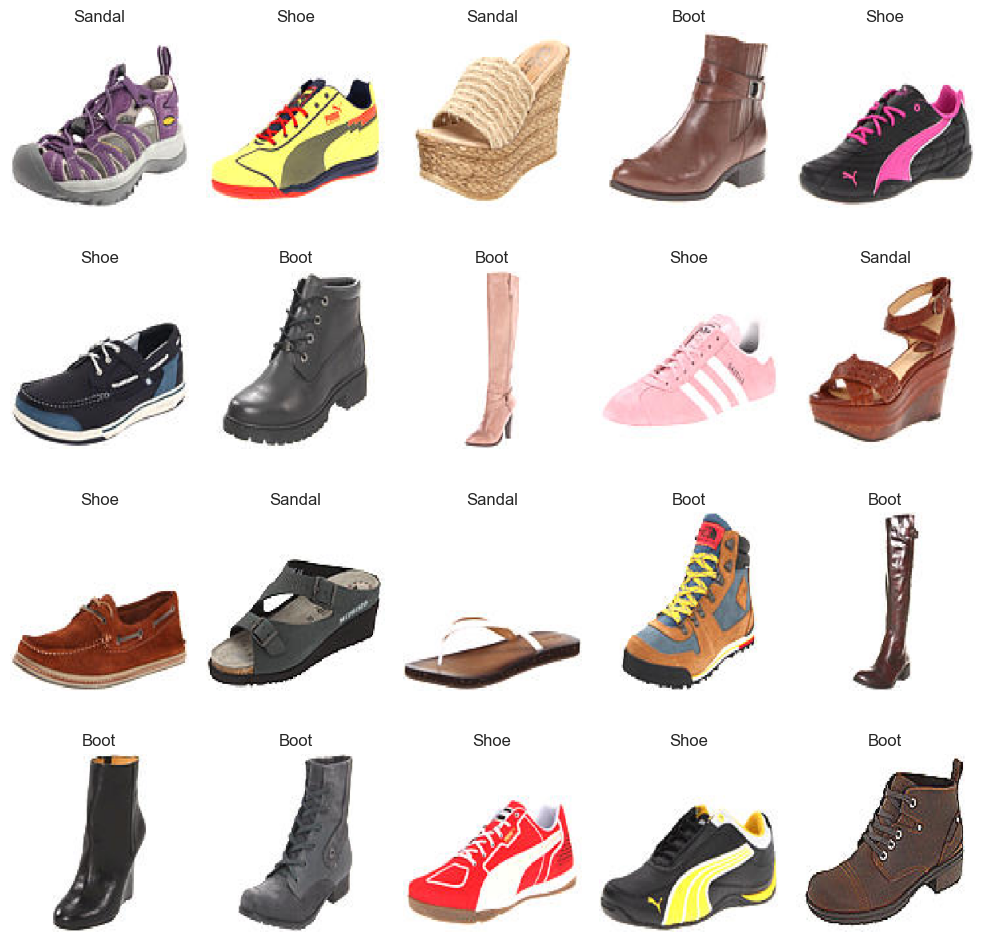

In [8]:
plot_random_images()

In [9]:
train_data, val_data

(<keras.src.preprocessing.image.DirectoryIterator at 0x1fd3f10ba00>,
 <keras.src.preprocessing.image.DirectoryIterator at 0x1fd3f10b610>)

In [10]:
model = tf.keras.Sequential([
            tf.keras.Input(shape = images[0].shape),
            tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2), strides=2),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dense(3, activation = 'softmax'),
])


model.compile(
    optimizer='adam', 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
    )


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [12]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [13]:
classifier = model.fit(train_data, batch_size = 50, 
                                 epochs = 12, 
                                 validation_data = val_data, 
                                 verbose = 1,
                                 callbacks = [reduce_lr])

Epoch 1/12

240/240 [==============================] - 433s 2s/step - loss: 0.5227 - accuracy: 0.8604 - val_loss: 0.1602 - val_accuracy: 0.9370 - lr: 0.0010
Epoch 2/12
240/240 [==============================] - 322s 1s/step - loss: 0.1322 - accuracy: 0.9543 - val_loss: 0.1164 - val_accuracy: 0.9560 - lr: 0.0010
Epoch 3/12
240/240 [==============================] - 624s 3s/step - loss: 0.0652 - accuracy: 0.9787 - val_loss: 0.1604 - val_accuracy: 0.9457 - lr: 0.0010
Epoch 4/12
240/240 [==============================] - 323s 1s/step - loss: 0.0313 - accuracy: 0.9887 - val_loss: 0.1746 - val_accuracy: 0.9440 - lr: 0.0010
Epoch 5/12
240/240 [==============================] - 321s 1s/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.1656 - val_accuracy: 0.9577 - lr: 0.0010
Epoch 6/12
240/240 [==============================] - 333s 1s/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.1964 - val_accuracy: 0.9547 - lr: 0.0010
Epoch 7/12
240/240 [==============================] - 359s 1s/s

In [31]:
# Set the number of epochs
epochs = 12  # You can adjust this number

# Set up TensorBoard callback with a fixed log directory
log_dir = "logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Assuming you have training and validation data
# Change 'train_data' and 'val_data' to your actual data generators
model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[tensorboard_callback])

# Load the TensorBoard extension with terminal
# tensorboard --logdir logs/fit

Epoch 1/12
240/240 [==============================] - 599s 2s/step - loss: 0.0195 - accuracy: 0.9935 - val_loss: 0.2909 - val_accuracy: 0.9443
Epoch 2/12
240/240 [==============================] - 513s 2s/step - loss: 0.0098 - accuracy: 0.9978 - val_loss: 0.2486 - val_accuracy: 0.9367
Epoch 3/12
240/240 [==============================] - 436s 2s/step - loss: 0.0049 - accuracy: 0.9985 - val_loss: 0.2725 - val_accuracy: 0.9547
Epoch 4/12
240/240 [==============================] - 463s 2s/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.3050 - val_accuracy: 0.9493
Epoch 5/12
240/240 [==============================] - 474s 2s/step - loss: 4.6712e-04 - accuracy: 0.9999 - val_loss: 0.2685 - val_accuracy: 0.9567
Epoch 6/12
240/240 [==============================] - 470s 2s/step - loss: 1.1540e-04 - accuracy: 1.0000 - val_loss: 0.2810 - val_accuracy: 0.9567
Epoch 7/12
240/240 [==============================] - 447s 2s/step - loss: 5.7860e-05 - accuracy: 1.0000 - val_loss: 0.2859 - val_accu

UsageError: Line magic function `%tensorboard` not found.


In [14]:
model.evaluate(val_data)

60/60 [==============================] - 12s 204ms/step - loss: 0.2335 - accuracy: 0.9407


[0.23346352577209473, 0.940666675567627]

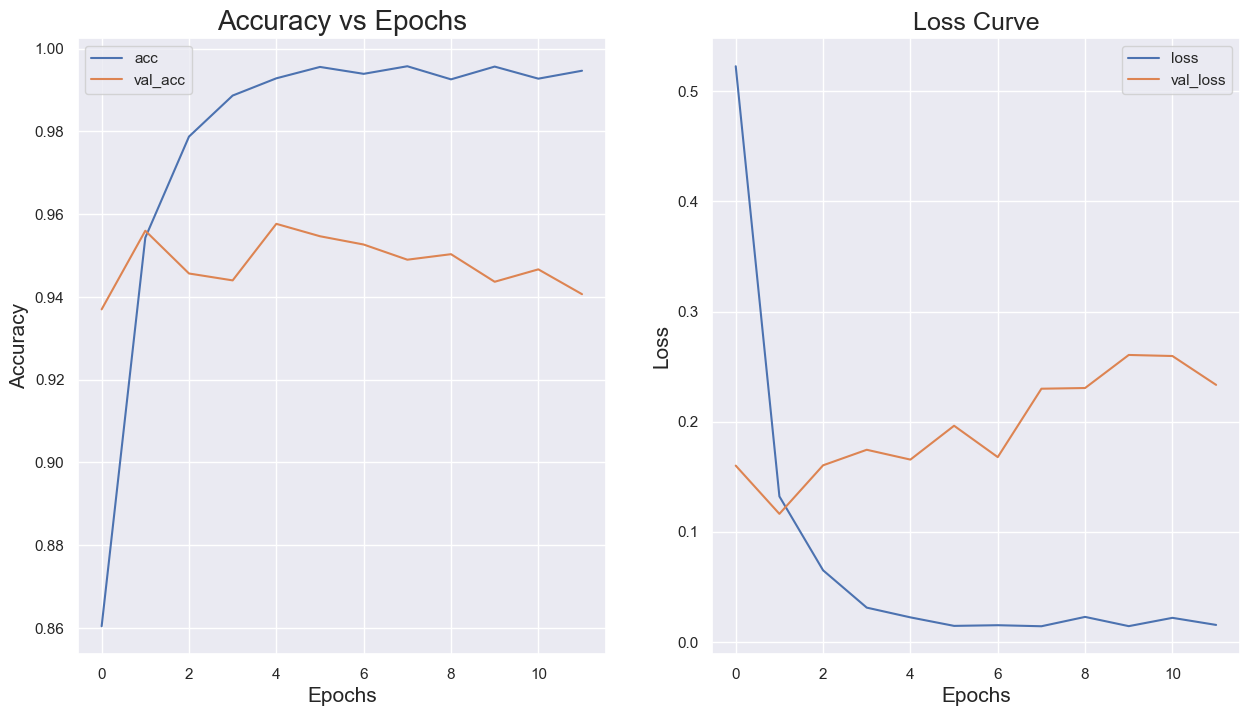

In [15]:
def model_performance_graphs():
    
    fig, axes = plt.subplots(1, 2, figsize = (15, 8))

    axes[0].plot(classifier.epoch, classifier.history['accuracy'], label = 'acc')
    axes[0].plot(classifier.epoch, classifier.history['val_accuracy'], label = 'val_acc')
    axes[0].set_title('Accuracy vs Epochs', fontsize = 20)
    axes[0].set_xlabel('Epochs', fontsize = 15)
    axes[0].set_ylabel('Accuracy', fontsize = 15)
    axes[0].legend()

    axes[1].plot(classifier.epoch, classifier.history['loss'], label = 'loss')
    axes[1].plot(classifier.epoch, classifier.history['val_loss'], label="val_loss")
    axes[1].set_title("Loss Curve",fontsize=18)
    axes[1].set_xlabel("Epochs",fontsize=15)
    axes[1].set_ylabel("Loss",fontsize=15)
    axes[1].legend()

    plt.show()
    
model_performance_graphs()


In [16]:
model.save('model.h5')

In [18]:
loaded_model = tf.keras.models.load_model('mod/model.h5')

In [19]:
def preprocess_images(path):
    img = image.load_img(path, target_size=(224, 224))

    img_array = image.img_to_array(img)

    img_array = np.expand_dims(img_array, axis=0)

    img_preprocessed = img_array / 255.0
    
    return img_preprocessed

In [20]:
img_path = "Shoe vs Sandal vs Boot Dataset/Shoe/Shoe (1).jpg"
img = preprocess_images(img_path)
prediction = loaded_model.predict(img)

predicted_class_index = np.argmax(prediction)

class_labels = ['Boot', 'Sandal', 'Shoe']  
predicted_class_label = class_labels[predicted_class_index]

print("Predicted class:", predicted_class_label)

1/1 [==============================] - 1s 1s/step
Predicted class: Shoe
